In [5]:
# import package
import arviz as az
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pymc as pm

In [6]:
df = pd.read_csv('diabetes.csv')

In [7]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [8]:
# replace 0 with NA for those variables
d=df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']]=df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.nan)
d.head()
d.isnull().sum()[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']]

Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

In [9]:
df.isnull().sum() # now we see some missing values for the variables

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [10]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


# Bayesian imputation using posterior predictive distribution

In [11]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [12]:
data = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']]

C:\Users\leonz\AppData\Local\Temp\ipykernel_21428\2796133354.py:16: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata = pm.sample_prior_predictive()
Sampling: [cov, mus, x_unobs]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mus, cov, x_unobs]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 158 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mus, cov, x_unobs]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 124 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
C:\Users\leonz\AppData\Local\Temp\ipykernel_21428\2796133354.py:19: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  pm.sample_posterior_predictive(idata, extend_inferencedata=True)


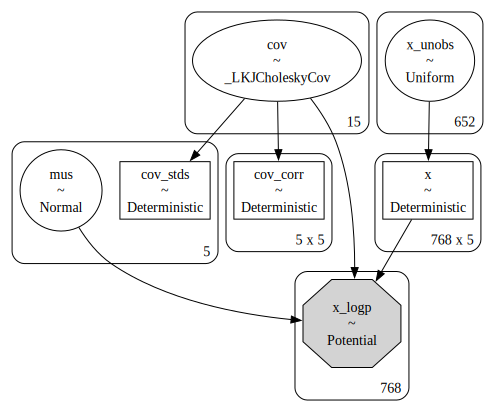

In [13]:
import pytensor.tensor as pt

with pm.Model() as model:
    # Priors
    mus = pm.Normal("mus", 0, 1, size=5)
    cov_flat_prior, _, _ = pm.LKJCholeskyCov("cov", n=5, eta=1.0, sd_dist=pm.Exponential.dist(1))
    # Create a vector of flat variables for the unobserved components of the MvNormal
    x_unobs = pm.Uniform("x_unobs", 0, 100, shape=(np.isnan(data.values).sum(),))

    # Create the symbolic value of x, combining observed data and unobserved variables
    x = pt.as_tensor(data.values)
    x = pm.Deterministic("x", pt.set_subtensor(x[np.isnan(data.values)], x_unobs))

    # Add a Potential with the logp of the variable conditioned on `x`
    pm.Potential("x_logp", pm.logp(rv=pm.MvNormal.dist(mus, chol=cov_flat_prior), value=x))
    idata = pm.sample_prior_predictive()
    idata = pm.sample()
    idata.extend(pm.sample(random_seed=120))
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

pm.model_to_graphviz(model)

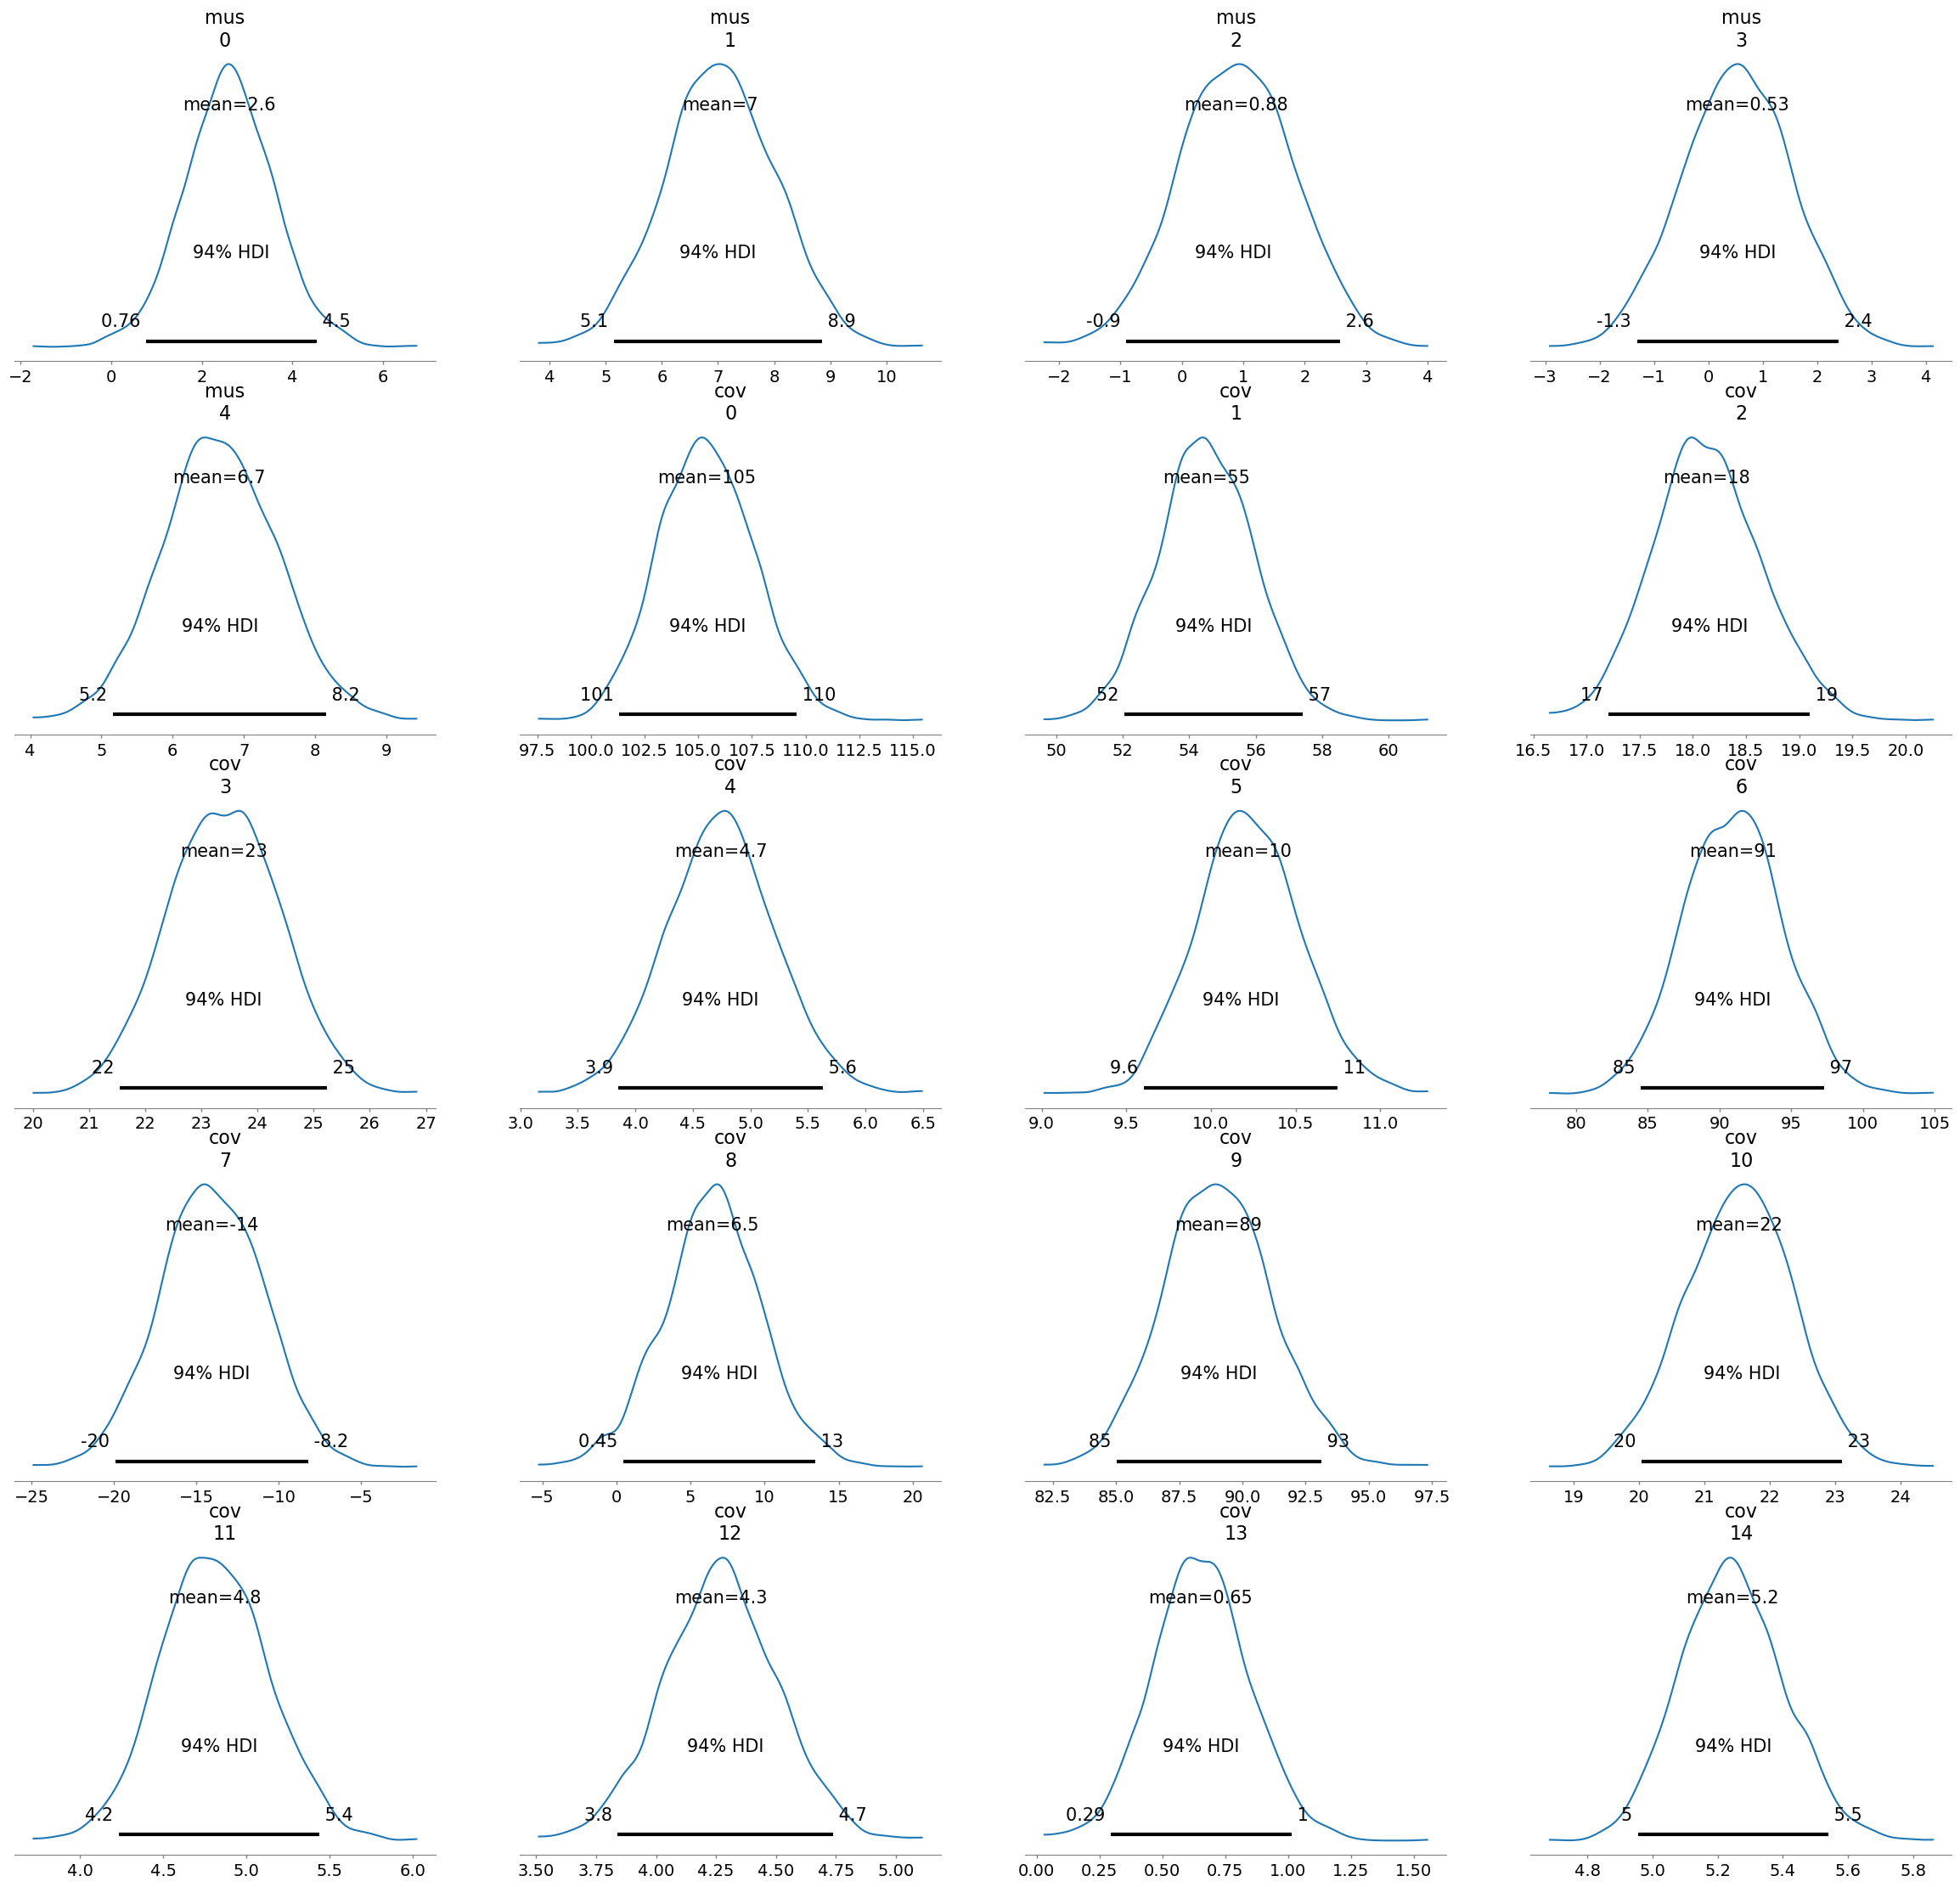

In [14]:
az.plot_posterior(idata, var_names=["mus", "cov"]);

In [15]:
az.summary(idata, var_names=["mus", "cov", "x_unobs"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mus[0],2.608,0.998,0.763,4.542,0.011,0.009,8291.0,2828.0,1.0
mus[1],7.044,0.989,5.145,8.851,0.012,0.008,7143.0,3040.0,1.0
mus[2],0.881,0.935,-0.904,2.581,0.011,0.011,6850.0,3241.0,1.0
mus[3],0.525,0.997,-1.315,2.396,0.010,0.015,10257.0,3130.0,1.0
mus[4],6.656,0.803,5.163,8.160,0.010,0.007,6696.0,3349.0,1.0
...,...,...,...,...,...,...,...,...,...
x_unobs[647],50.660,28.685,6.401,99.884,0.310,0.253,8346.0,1940.0,1.0
x_unobs[648],56.643,27.335,10.879,99.961,0.316,0.226,7937.0,2098.0,1.0
x_unobs[649],26.657,7.772,11.925,40.883,0.101,0.072,5827.0,2476.0,1.0
x_unobs[650],56.922,27.581,10.534,99.991,0.304,0.227,8876.0,2400.0,1.0


In [16]:
imputed_dims = data.shape
imputed = data.values.flatten()
imputed[np.isnan(imputed)] = az.summary(idata, var_names=["x_unobs"])["mean"].values
imputed = imputed.reshape(imputed_dims[0], imputed_dims[1])
#imputed = pd.DataFrame(imputed, columns=[col + "_imputed" for col in data.columns])
imputed = pd.DataFrame(imputed, columns=[col for col in data.columns])
imputed.head(10)

,Glucose,BloodPressure,SkinThickness,Insulin,BMI
0,148.0,72.000,35.000,58.342,33.600
1,85.0,66.000,29.000,50.508,26.600
2,183.0,64.000,21.751,61.080,23.300
3,89.0,66.000,23.000,94.000,28.100
4,137.0,40.000,35.000,168.000,43.100
5,116.0,74.000,22.165,52.722,25.600
6,78.0,50.000,32.000,88.000,31.000
7,115.0,72.566,31.398,55.304,35.300
8,197.0,70.000,45.000,543.000,30.500
9,125.0,96.000,34.802,53.589,38.225


In [17]:
imputed.describe()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI
count,768.000000,768.000000,768.000000,768.000000,768.000000
mean,121.401915,72.158089,28.764128,106.417839,32.398219
std,30.643231,12.447919,9.541807,98.899684,6.915331
min,44.000000,24.000000,7.000000,14.000000,18.200000
25%,99.000000,64.000000,22.000000,53.313750,27.475000
50%,117.000000,72.000000,28.060000,58.912500,32.050000
75%,140.250000,80.000000,35.000000,127.250000,36.600000
max,199.000000,122.000000,99.000000,846.000000,67.100000


In [18]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


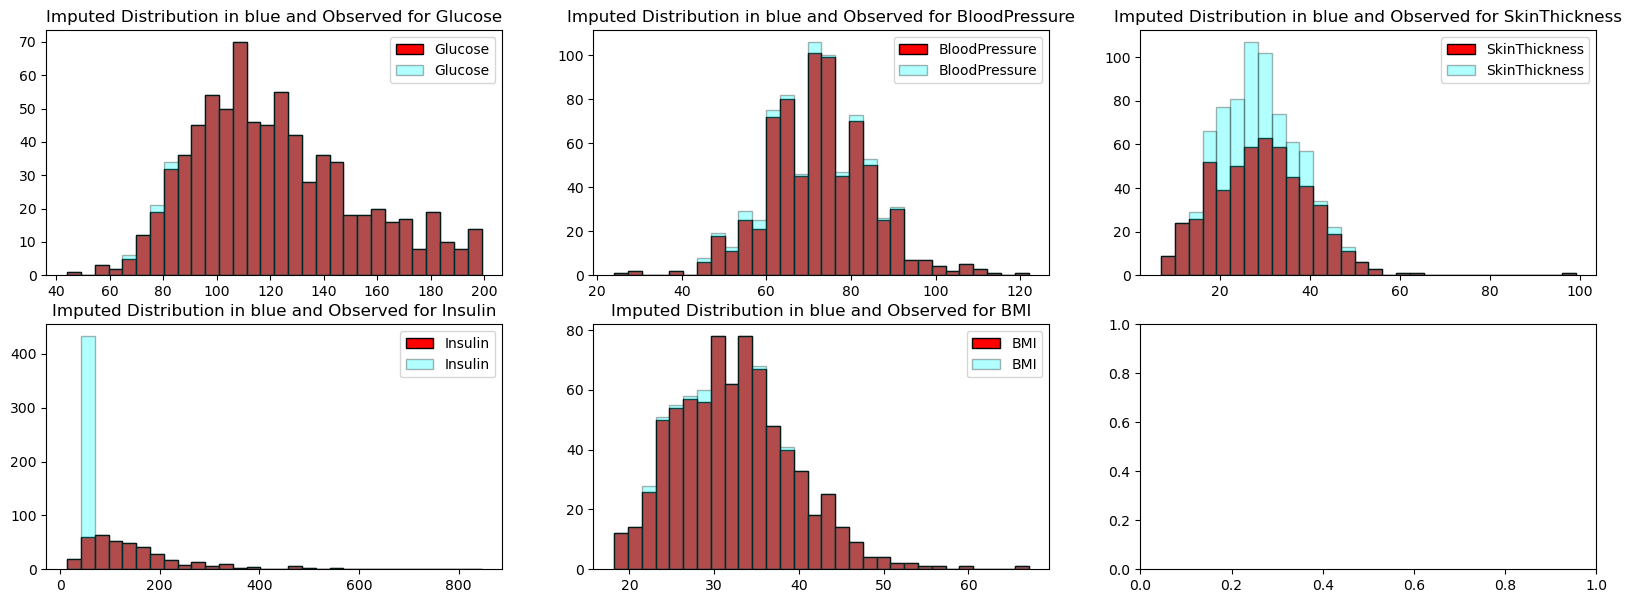

In [110]:
fig, axs = plt.subplots(2, 3, figsize=(20, 7))
axs = axs.flatten()
for col, col_i, ax in zip(data.columns, imputed.columns, axs):
    ax.hist(data[col], color="red", label=col, ec="black", bins=30)
    ax.hist(imputed[col_i], color="cyan", alpha=0.3, label=col_i, ec="black", bins=30)
    ax.legend()
    ax.set_title(f"Imputed Distribution in blue and Observed for {col}")

In [20]:
df2 = df.drop(['Glucose','BloodPressure','SkinThickness','Insulin','BMI'], axis = 1)
df2.head(10)

,Pregnancies,DiabetesPedigreeFunction,Age,Outcome
0,6,0.627,50,1
1,1,0.351,31,0
2,8,0.672,32,1
3,1,0.167,21,0
4,0,2.288,33,1
5,5,0.201,30,0
6,3,0.248,26,1
7,10,0.134,29,0
8,2,0.158,53,1
9,8,0.232,54,1


In [21]:
diabetes_imputed = pd.concat([df2, imputed], axis=1)

In [22]:
diabetes_imputed.head()

,Pregnancies,DiabetesPedigreeFunction,Age,Outcome,Glucose,BloodPressure,SkinThickness,Insulin,BMI
0,6,0.627,50,1,148.0,72.0,35.000,58.342,33.6
1,1,0.351,31,0,85.0,66.0,29.000,50.508,26.6
2,8,0.672,32,1,183.0,64.0,21.751,61.080,23.3
3,1,0.167,21,0,89.0,66.0,23.000,94.000,28.1
4,0,2.288,33,1,137.0,40.0,35.000,168.000,43.1


In [23]:
diabetes_imputed.describe()

,Pregnancies,DiabetesPedigreeFunction,Age,Outcome,Glucose,BloodPressure,SkinThickness,Insulin,BMI
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,0.471876,33.240885,0.348958,121.401915,72.158089,28.764128,106.417839,32.398219
std,3.369578,0.331329,11.760232,0.476951,30.643231,12.447919,9.541807,98.899684,6.915331
min,0.000000,0.078000,21.000000,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000
25%,1.000000,0.243750,24.000000,0.000000,99.000000,64.000000,22.000000,53.313750,27.475000
50%,3.000000,0.372500,29.000000,0.000000,117.000000,72.000000,28.060000,58.912500,32.050000
75%,6.000000,0.626250,41.000000,1.000000,140.250000,80.000000,35.000000,127.250000,36.600000
max,17.000000,2.420000,81.000000,1.000000,199.000000,122.000000,99.000000,846.000000,67.100000


In [24]:
#diabetes_imputed.to_csv("diabetes_imputed.csv")

# Bayesian imputation using chained equations

In [25]:
data2 = pd.read_csv('diabetes.csv')
# replace 0 with NA for those variables
d2=data2[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']]=data2[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.nan)
d2.head()
d2.isnull().sum()[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']]

Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

In [26]:
data2.isnull().sum() # now we see some missing values for the variables

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [27]:
data2.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [28]:
# bmi
bmi_mean = data2["BMI"].mean()
bmi_min = data2["BMI"].min()
bmi_max = data2["BMI"].max()
bmi_sd = data2["BMI"].std()

# insulin
insulin_mean = data2["Insulin"].mean()
insulin_min = data2["Insulin"].min()
insulin_max = data2["Insulin"].max()
insulin_sd = data2["Insulin"].std()

# skinthickness
skinthickness_mean = data2["SkinThickness"].mean()
skinthickness_min = data2["SkinThickness"].min()
skinthickness_max = data2["SkinThickness"].max()
skinthickness_sd = data2["SkinThickness"].std()

# bloodpressure
bloodpressure_mean = data2["BloodPressure"].mean()
bloodpressure_min = data2["BloodPressure"].min()
bloodpressure_max = data2["BloodPressure"].max()
bloodpressure_sd = data2["BloodPressure"].std()



D:\anaconda3\envs\pymc_env\Lib\site-packages\pymc\model\core.py:1326: ImputationWarning: Data in bmi_pred contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
D:\anaconda3\envs\pymc_env\Lib\site-packages\pymc\model\core.py:1326: ImputationWarning: Data in insulin_pred contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
D:\anaconda3\envs\pymc_env\Lib\site-packages\pymc\model\core.py:1326: ImputationWarning: Data in skinthickness_pred contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
D:\anaconda3\envs\pymc_env\Lib\site-packages\pymc\model\core.py:1326: ImputationWarning: Data in bloodpressure_pred contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, Imputat

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 240 seconds.
Sampling: [bloodpressure_imputed_observed, bloodpressure_imputed_unobserved, bloodpressure_pred_observed, bmi_imputed_observed, bmi_pred_observed, glucose_imputed_observed, glucose_imputed_unobserved, insulin_imputed_observed, insulin_imputed_unobserved, insulin_pred_observed, skinthickness_imputed_observed, skinthickness_imputed_unobserved, skinthickness_pred_observed]


Output()

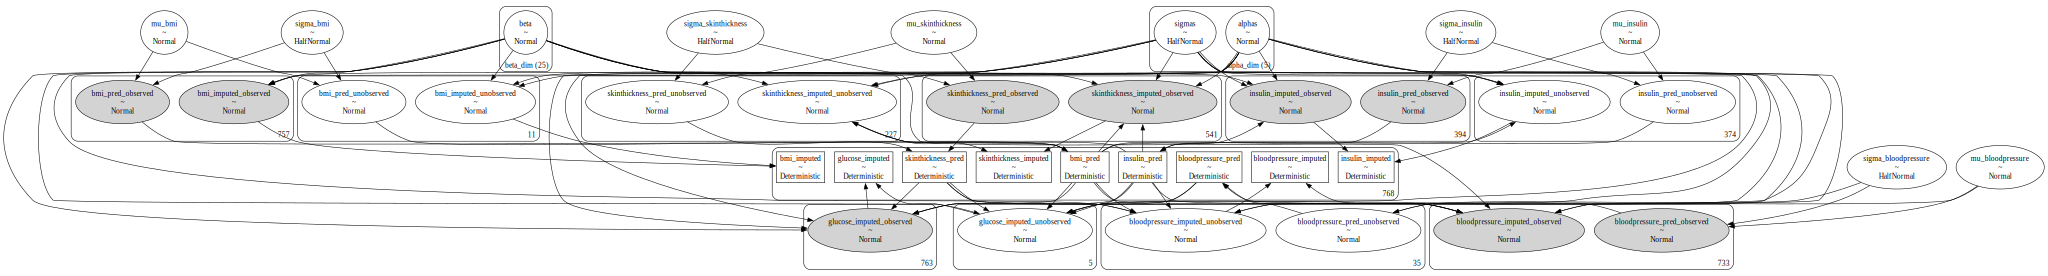

In [73]:

priors = {
    "bmi": {"normal": [bmi_mean, bmi_sd, bmi_sd], "uniform": [bmi_min, bmi_max]},
    "insulin": {"normal": [insulin_mean, insulin_sd, insulin_sd], "uniform": [insulin_min, insulin_max]},
    "skinthickness": {"normal": [skinthickness_mean, skinthickness_sd, skinthickness_sd], "uniform": [skinthickness_min, skinthickness_max]},
    "bloodpressure": {"normal": [bloodpressure_mean, bloodpressure_sd, bloodpressure_sd], "uniform": [bloodpressure_min, bloodpressure_max]}
    
}

def make_model(priors, normal_pred_assumption=True):
    coords = {
        "alpha_dim": ["bmi_imputed", "insulin_imputed", "skinthickness_imputed", "bloodpressure_imputed", "glucose_imputed"],
        "beta_dim": [
            # betas for bmi:
            "bmiB_preg",
            "bmiB_diaF",
            "bmiB_Age",
            # betas for insulin:
            "insulinB_bmi",
            "insulinB_preg",
            "insulinB_diaF",
            "insulinB_age",
            # betas for skinthickness:
            "skinthicknessB_bmi",
            "skinthicknessB_insulin",
            "skinthicknessB_preg",
            "skinthicknessB_diaF",
            "skinthicknessB_age",
            # betas for bloodpressure:
            "bloodpressureB_bmi",
            "bloodpressureB_insulin",
            "bloodpressureB_skinthickness",
            "bloodpressureB_preg",
            "bloodpressureB_diaF",
            "bloodpressureB_age",
             # betas for glucose:
            "glucoseB_bmi",
            "glucoseB_insulin",
            "glucoseB_skinthickness",
            "glucoseB_bloodpressure",
            "glucoseB_preg",
            "glucoseB_diaF",
            "glucoseB_age",   
        ],
    }
    with pm.Model(coords=coords) as model:
        # Priors
        beta = pm.Normal("beta", mu=0, sigma=100, size=25, dims="beta_dim")
        alpha = pm.Normal("alphas", mu=0, sigma=100, size=5, dims="alpha_dim")
        sigma = pm.HalfNormal("sigmas", sigma=5, size=5, dims="alpha_dim")

########################################################################################################################################
        #normal assumptions
        # bmi
        if normal_pred_assumption:
            mu_bmi = pm.Normal(
                "mu_bmi", priors["bmi"]["normal"][0], priors["bmi"]["normal"][1]
            )
            sigma_bmi = pm.HalfNormal("sigma_bmi", priors["bmi"]["normal"][2])
            bmi_pred = pm.Normal(
                "bmi_pred", mu_bmi, sigma_bmi, observed=data2["BMI"].values
            )
        else:
            bmi_pred = pm.Uniform("bmi_pred", 5, 100, observed=data2["BMI"].values, initval=bmi_min)

        # insulin
        if normal_pred_assumption:
            mu_insulin = pm.Normal("mu_insulin", priors["insulin"]["normal"][0], priors["insulin"]["normal"][1])
            sigma_insulin = pm.HalfNormal("sigma_insulin", priors["insulin"]["normal"][2])
            insulin_pred = pm.Normal("insulin_pred", mu_insulin, sigma_insulin, observed=data2["Insulin"].values)
        else:
            insulin_pred = pm.Uniform("insulin_pred", 5, 100, observed=data2["Insulin"].values, initval=insulin_min)

        # skinthickness
        if normal_pred_assumption:
            mu_skinthickness = pm.Normal("mu_skinthickness", priors["skinthickness"]["normal"][0], priors["skinthickness"]["normal"][1])
            sigma_skinthickness = pm.HalfNormal("sigma_skinthickness", priors["skinthickness"]["normal"][2])
            skinthickness_pred = pm.Normal("skinthickness_pred", mu_skinthickness, sigma_skinthickness, observed=data2["SkinThickness"].values)
        else:
            skinthickness_pred = pm.Uniform("skinthicknesspred", 5, 100, observed=data2["SkinThickness"].values, initval=skinthickness_min)

        # bloodpressure
        if normal_pred_assumption:
            mu_bloodpressure = pm.Normal("mu_bloodpressure", priors["bloodpressure"]["normal"][0], priors["bloodpressure"]["normal"][1])
            sigma_bloodpressure = pm.HalfNormal("sigma_bloodpressure", priors["bloodpressure"]["normal"][2])
            bloodpressure_pred = pm.Normal("bloodpressure_pred", mu_bloodpressure, sigma_bloodpressure, observed=data2["BloodPressure"].values)
        else:
            bloodpressure_pred = pm.Uniform("bloodpressure_pred", 5, 100, observed=data2["BloodPressure"].values, initval=bloodpressure_min)
########################################################################################################################################
        # Likelihood(s)
        # bmi
        bmi_imputed = pm.Normal(
        #pm.TruncatedNormal(
            "bmi_imputed",
            mu=alpha[0] + beta[0]*data2["Pregnancies"] + beta[1]*data2["DiabetesPedigreeFunction"] + beta[2]*data2["Age"],
            sigma=sigma[0],
            #lower = 2,
            observed=data2["BMI"].values,
        )
        # insulin
        insulin_imputed = pm.Normal(
        #pm.TruncatedNormal(
        
            "insulin_imputed",
            mu = alpha[1] + beta[3]*bmi_pred + beta[4]*data2["Pregnancies"] + beta[5]*data2["DiabetesPedigreeFunction"] + beta[6]*data2["Age"],
            sigma = sigma[1],
            #lower = 2,
            observed=data["Insulin"].values,
        )
        # skinthickness
        skinthickness_imputed = pm.Normal(
        #pm.TruncatedNormal(
            "skinthickness_imputed",
            mu =alpha[2] + beta[7]*bmi_pred + beta[8]*insulin_pred  + beta[9]*data2["Pregnancies"] + beta[10]*data2["DiabetesPedigreeFunction"] + beta[11]*data2["Age"],
            sigma= sigma[2],
            #lower = 2,
            observed=data2["SkinThickness"].values,
        )
        # bloodpressure
        bloodpressure_imputed = pm.Normal(#pm.TruncatedNormal(
            "bloodpressure_imputed",
            mu =alpha[3] + beta[12]*bmi_pred + beta[13]*insulin_pred + beta[14]*skinthickness_pred + beta[15]*data2["Pregnancies"] + beta[16]*data2["DiabetesPedigreeFunction"] + beta[17]*data2["Age"],
            sigma= sigma[3],
            #lower = 2,
            observed=data2["BloodPressure"].values,
        )
        # glucose
        glucose_imputed = pm.Normal(
        #pm.TruncatedNormal(
            "glucose_imputed",
            mu = alpha[4] + beta[18]*bmi_pred + beta[19]*insulin_pred + beta[20]*skinthickness_pred  + beta[21]*bloodpressure_pred + beta[22]*data2["Pregnancies"] + beta[23]*data2["DiabetesPedigreeFunction"] + beta[24]*data2["Age"],
            sigma=sigma[4],
            #lower = 2,
            observed=data2["Glucose"].values,
        )


        idata = pm.sample_prior_predictive()
        idata.extend(pm.sample(random_seed=2024))
        pm.sample_posterior_predictive(idata, extend_inferencedata=True)

        return idata, model


#idata_uniform, model_uniform = make_model(priors, normal_pred_assumption=False)
idata_normal, model_normal = make_model(priors, normal_pred_assumption=True)
pm.model_to_graphviz(model_normal)

In [83]:
az.summary(idata_normal, var_names=["alphas", "beta", "sigmas"], stat_focus="median")

,median,mad,eti_3%,eti_97%,mcse_median,ess_median,ess_tail,r_hat
alphas[bmi_imputed],30.575,0.557,29.024,32.135,0.011,5694.075,3024.0,1.0
alphas[insulin_imputed],-47.355,15.514,-90.617,-5.053,0.451,3767.505,3305.0,1.0
alphas[skinthickness_imputed],-6.304,1.298,-9.727,-2.693,0.035,4775.061,3290.0,1.0
alphas[bloodpressure_imputed],45.318,1.589,41.022,49.888,0.027,6380.342,3376.0,1.0
alphas[glucose_imputed],48.466,4.406,36.146,60.904,0.104,5273.347,3297.0,1.0
beta[bmiB_preg],0.044,0.061,-0.125,0.210,0.002,6333.811,2958.0,1.0
beta[bmiB_diaF],3.244,0.532,1.816,4.693,0.011,6897.960,2698.0,1.0
beta[bmiB_Age],0.005,0.017,-0.043,0.054,0.000,6046.276,2836.0,1.0
beta[insulinB_bmi],3.247,0.420,2.101,4.391,0.010,4101.322,3214.0,1.0
beta[insulinB_preg],-3.399,1.238,-6.936,0.134,0.036,3193.583,3038.0,1.0


array([[<Axes: xlabel='bloodpressure_imputed_observed'>,
        <Axes: xlabel='bloodpressure_pred_observed'>,
        <Axes: xlabel='bmi_imputed_observed'>],
       [<Axes: xlabel='bmi_pred_observed'>,
        <Axes: xlabel='glucose_imputed_observed'>,
        <Axes: xlabel='insulin_imputed_observed'>],
       [<Axes: xlabel='insulin_pred_observed'>,
        <Axes: xlabel='skinthickness_imputed_observed'>,
        <Axes: xlabel='skinthickness_pred_observed'>]], dtype=object)

D:\anaconda3\envs\pymc_env\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
D:\anaconda3\envs\pymc_env\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


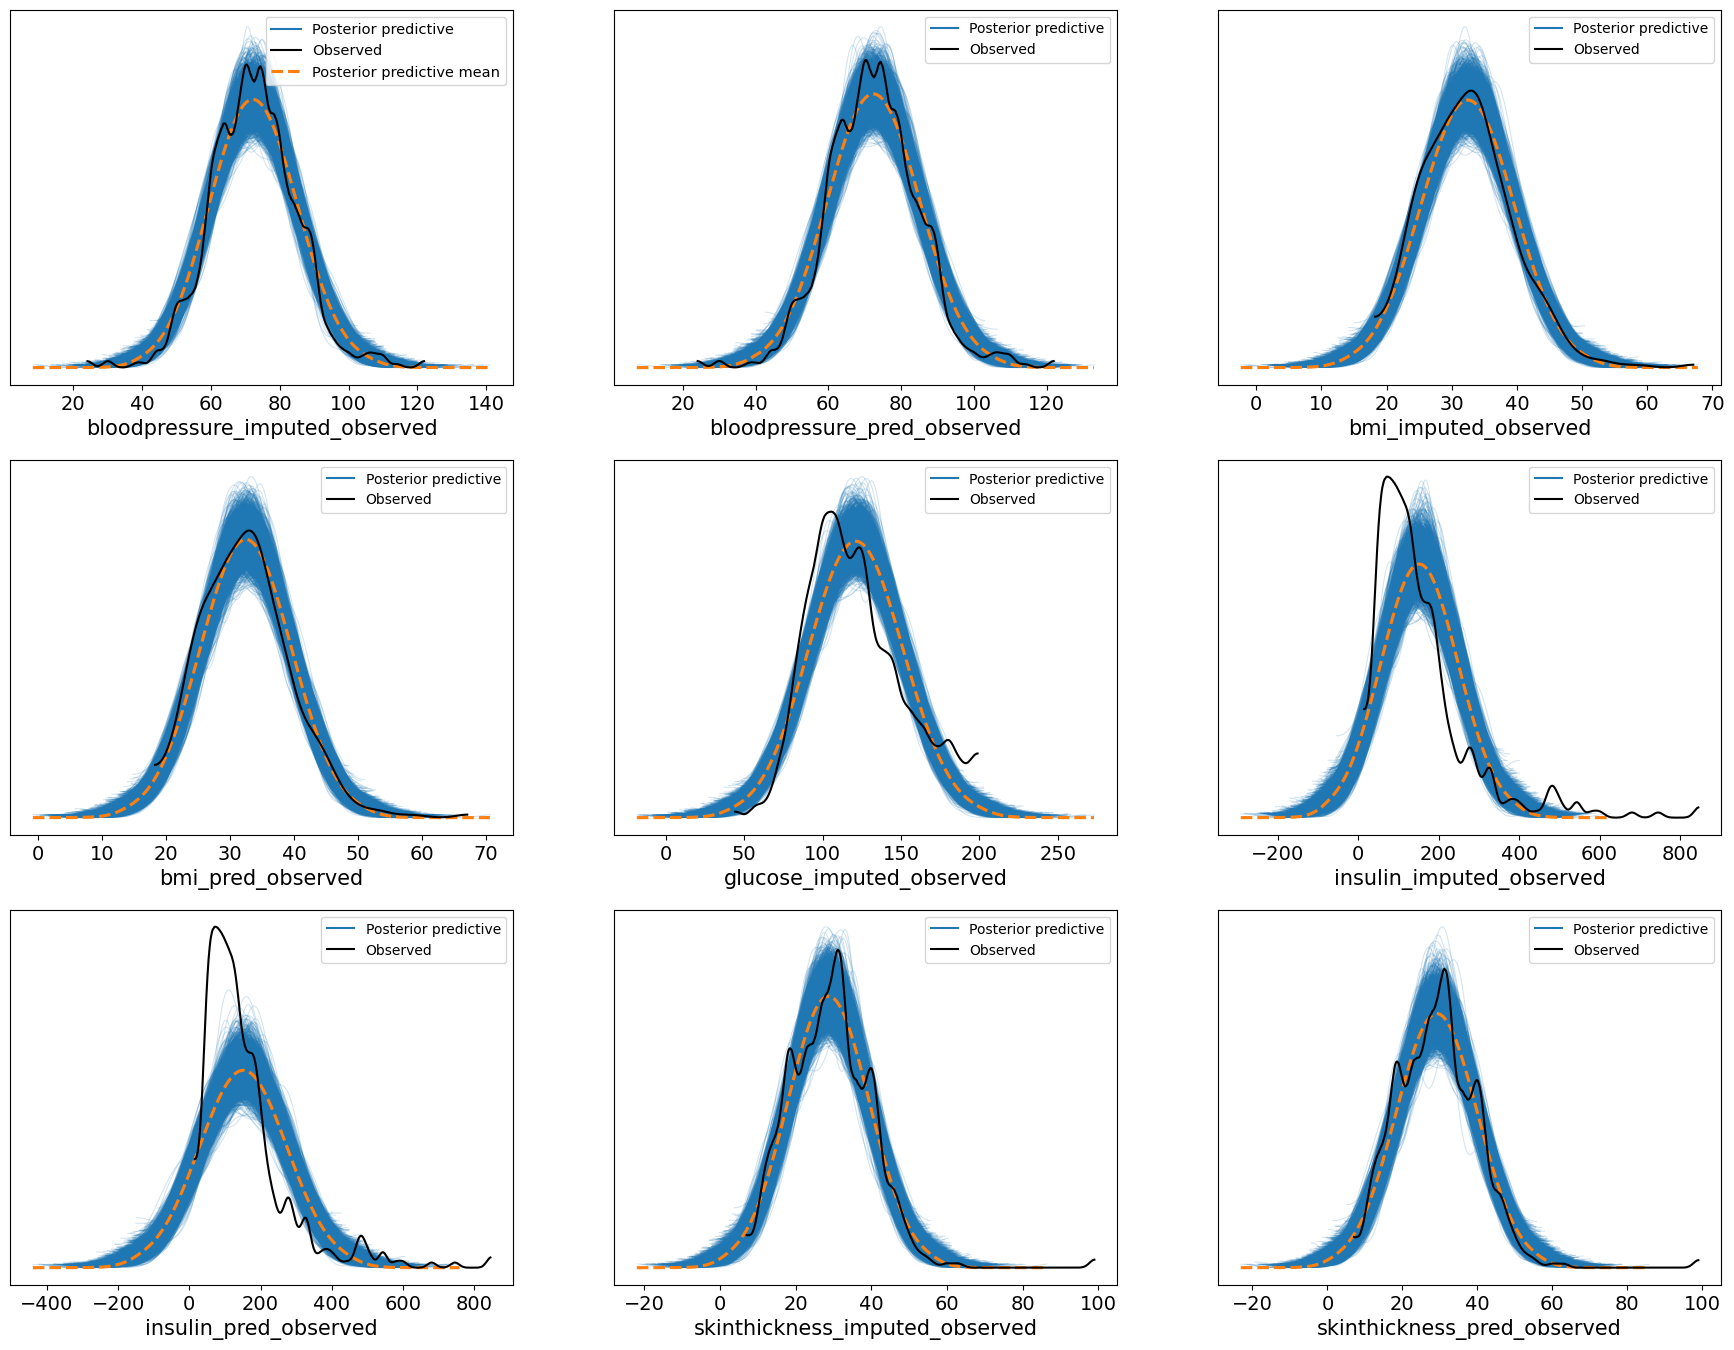

In [75]:
az.plot_ppc(idata_normal)

In [76]:
## get the imputed data
def get_imputed(idata, data):
    imputed_data = data.copy()

    # glucose
    imputed_glucose = az.extract(idata, group="posterior_predictive", num_samples=1000)[
        "glucose_imputed"
    ].mean(axis=1)
    mask = imputed_data["Glucose"].isnull()
    imputed_data.loc[mask, "Glucose"] = imputed_glucose.values[imputed_data[mask].index]

    # bloodpressure
    imputed_bloodpressure = az.extract(idata, group="posterior_predictive", num_samples=5000)[
        "bloodpressure_imputed"
    ].mean(axis=1)
    mask = imputed_data["BloodPressure"].isnull()
    imputed_data.loc[mask, "BloodPressure"] = imputed_bloodpressure.values[imputed_data[mask].index]

    #skinthickness
    imputed_skinthickness = az.extract(idata, group="posterior_predictive", num_samples=1000)[
        "skinthickness_imputed"
    ].mean(axis=1)
    mask = imputed_data["SkinThickness"].isnull()
    imputed_data.loc[mask, "SkinThickness"] = imputed_skinthickness.values[imputed_data[mask].index]

    #insulin
    imputed_insulin = az.extract(idata, group="posterior_predictive", num_samples=1000)[
        "insulin_imputed"
    ].mean(axis=1)
    mask = imputed_data["Insulin"].isnull()
    imputed_data.loc[mask, "Insulin"] = imputed_insulin.values[imputed_data[mask].index]
    
    #bmi
    imputed_bmi = az.extract(idata, group="posterior_predictive", num_samples=1000)[
        "bmi_imputed"
    ].mean(axis=1)
    mask = imputed_data["BMI"].isnull()
    imputed_data.loc[mask, "BMI"] = imputed_bmi.values[imputed_data[mask].index]
    
    
    assert imputed_data.isnull().sum().to_list() == [0, 0, 0, 0, 0, 0, 0, 0, 0] # ensure no NA values
    imputed_data.columns = [ col for col in imputed_data.columns] # "imputed_" +
    return imputed_data


In [77]:
imputed_data_normal = get_imputed(idata_normal, data2)
imputed_data_normal.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.00000,35.000000,208.169083,33.600000,0.627,50,1
1,1,85.0,66.00000,29.000000,157.620259,26.600000,0.351,31,0
2,8,183.0,64.00000,29.522514,146.807322,23.300000,0.672,32,1
3,1,89.0,66.00000,23.000000,94.000000,28.100000,0.167,21,0
4,0,137.0,40.00000,35.000000,168.000000,43.100000,2.288,33,1
5,5,116.0,74.00000,28.313905,131.672830,25.600000,0.201,30,0
6,3,78.0,50.00000,32.000000,88.000000,31.000000,0.248,26,1
7,10,115.0,72.55654,29.083141,113.938668,35.300000,0.134,29,0
8,2,197.0,70.00000,45.000000,543.000000,30.500000,0.158,53,1
9,8,125.0,96.00000,33.285207,213.104630,32.060241,0.232,54,1


In [78]:
imputed_data_normal.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [79]:
imputed_data_normal.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.670300,72.371121,29.199634,158.749804,32.456407,0.471876,33.240885,0.348958
std,3.369578,30.439049,12.116049,8.824640,88.954459,6.877164,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,118.209846,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.094191,144.264773,32.159336,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.287443,183.020372,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


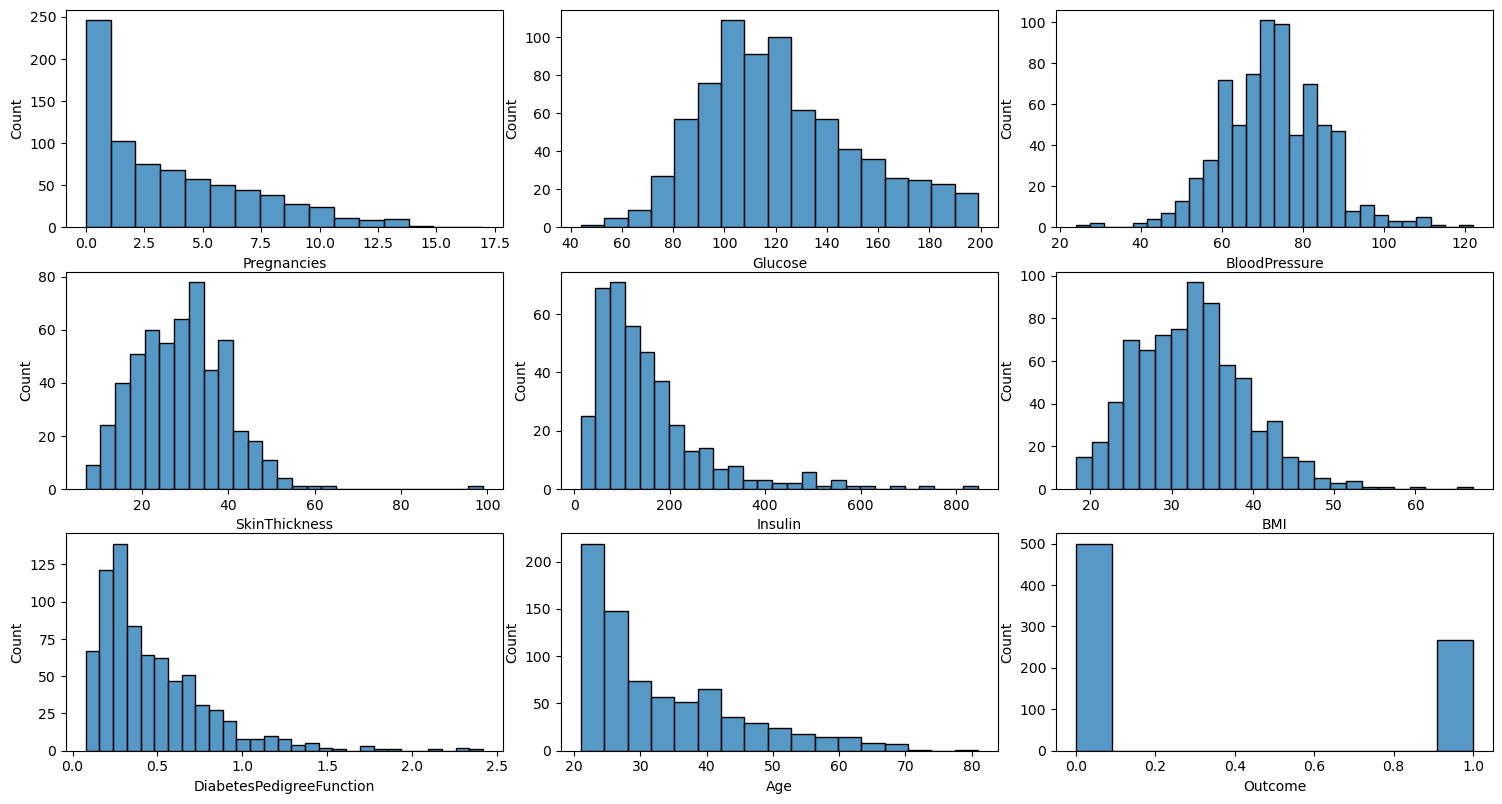

In [80]:
fig, axes = plt.subplots(3,3, figsize = (15,8))
#factors_df = df.drop(["Outcome"], axis = 1)
plt.tight_layout()
for j, i in enumerate(imputed_data_normal.columns.tolist()):
    x= j%3
    y= j//3 
    sns.histplot(ax= axes[y, x],
                 x= df[i])
    
plt.show()

In [84]:
imputed2 = imputed_data_normal[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']]
data_wmiss = data2[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']]

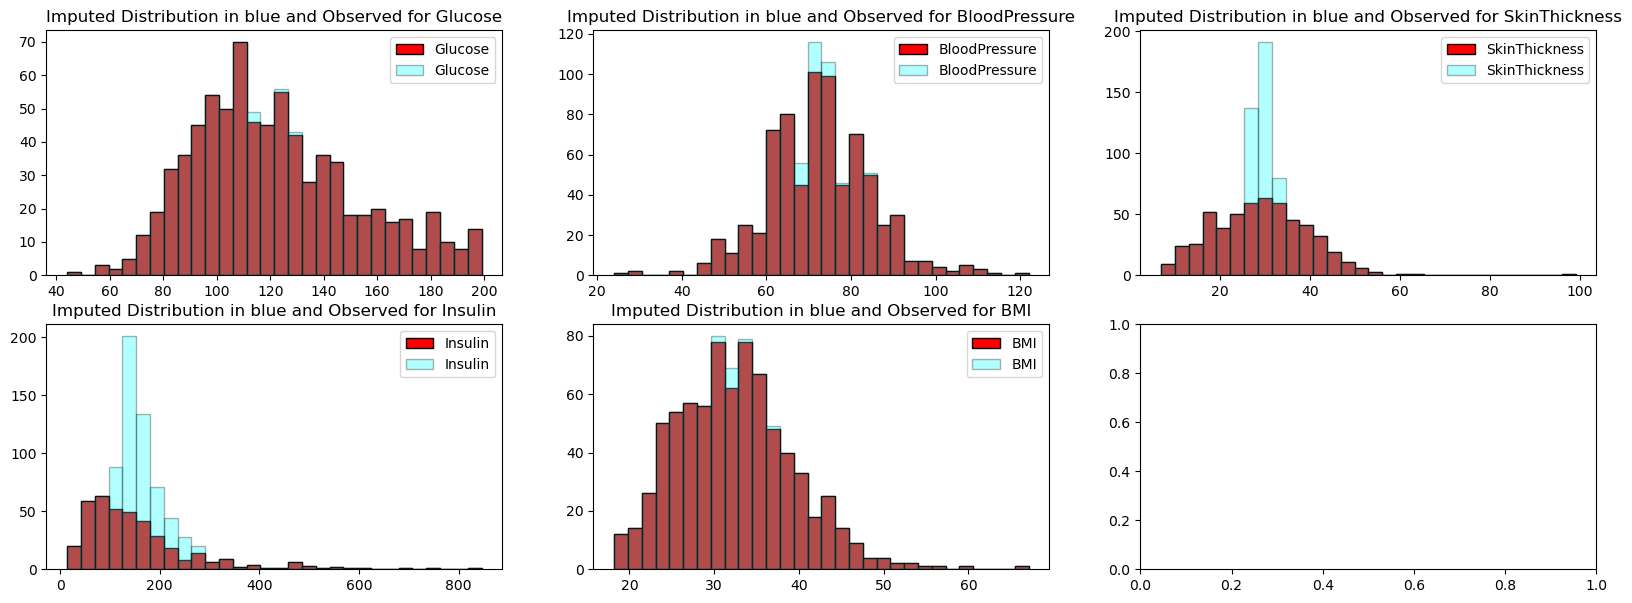

In [106]:
fig, axs = plt.subplots(2, 3, figsize=(20, 7))
axs = axs.flatten()
for col, col_i, ax in zip(data_wmiss.columns, imputed2.columns, axs):
    ax.hist(data_wmiss[col], color="red", label=col, ec="black", bins=30)
    ax.hist(imputed2[col_i], color="cyan", label=col_i, ec="black", bins=30, alpha=0.3)
    ax.legend()
    ax.set_title(f"Imputed Distribution in blue and Observed for {col}")

In [107]:
#imputed_data_normal.to_csv("diabetes_imputed_CE.csv")